In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
df=pd.read_csv('/content/combined_social_data_features.csv')

In [8]:
df

,account_name,caption,comment_count,share_count,like_count,platform,hashtags,mentions,engagement_score,caption_length,word_count,sentiment_score,hashtag_count,mention_count
0,McDonald's,SWIPE TO SEE WHAT PRIZES ARE LEFT!!! IT’S NOT ...,128,31,299,Facebook,NaN,NaN,458,149,29,0.303516,0,0
1,McDonald's,6 episodes\n25 Grimace family members\n1 wacky...,413,59,462,Facebook,NaN,NaN,934,92,16,0.425000,0,0
2,McDonald's,my dms can rest now,612,33,393,Facebook,NaN,NaN,1038,19,5,0.000000,0,0
3,McDonald's,MONOPOLY IS BACK AT McD’S! AVAILABLE ALL DAY! ...,1781,792,2677,Facebook,NaN,NaN,5250,122,23,0.195833,0,0
4,McDonald's,it all started with a McDonald's napkin... a s...,271,71,363,Facebook,NaN,NaN,705,117,19,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,gucci,"Attending the premiere for THE TIGER in Milan,...",461,0,35299,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@alanabc', '@biancahuisman_', '@alexconsani'...",35760,250,36,0.200000,3,18
1792,gucci,Not all answers float to the top.\n\nWatch THE...,234,0,51340,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@keke', '@halinareijn', '@elliotpage']",51574,111,17,0.500000,3,3
1793,gucci,THE TIGER\n\nA short film by Spike Jonze and H...,1026,0,100009,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@demimoore', '@halinareijn', '@elliotpage', ...",101035,325,46,0.000000,3,4
1794,gucci,What do you do if you’re in a room with a tige...,354,0,32990,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@keke', '@demimoore', '@kendalljenner', '@ha...",33344,202,36,0.200000,3,8


**we are going to plot Correlation heatmap to visualiza Correlation between columns**

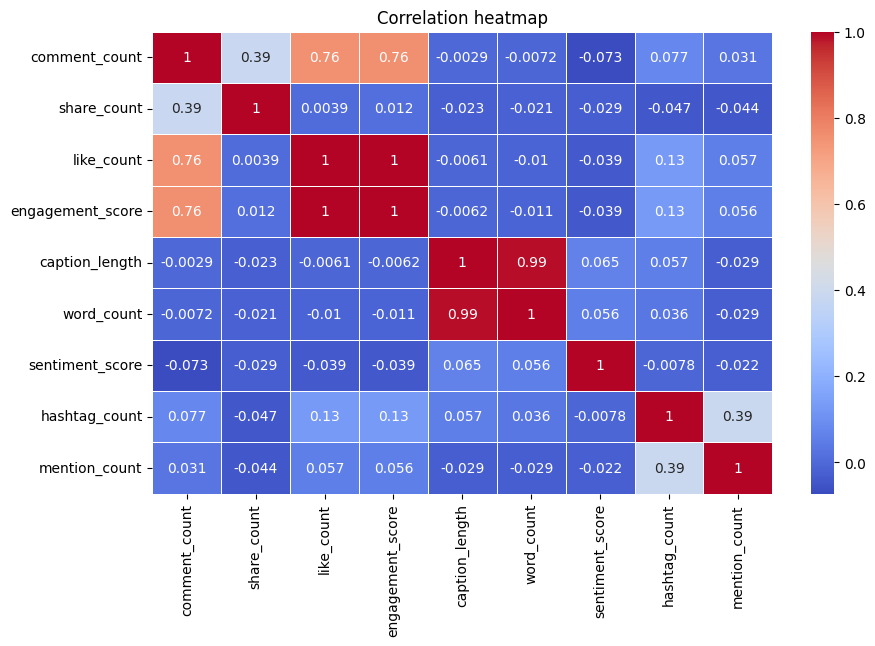

In [10]:
num_df = df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

In [ ]:
df.isnull().sum()

**due to so much missing values we are going to remove share, hashtags and mention related columns after that we should also recalculate the engagement_score column**

In [13]:
df = df.drop(['share_count', 'mentions', 'hashtags','engagement_score','hashtag_count','mention_count'], axis=1)

In [14]:
df["engagement_score"]=df["like_count"]+df["comment_count"]


In [27]:
df.isnull().sum()

,0
account_name,0
caption,0
comment_count,0
like_count,0
platform,0
caption_length,0
word_count,0
sentiment_score,0
engagement_score,0


**now we are going to work on caption column**

In [11]:
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'\n', ' ', text)  # remove newline chars
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['caption'] = df['caption'].astype(str).apply(clean_text)

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))
df['caption'] = df['caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**we are going to visualize the top 20 Brands by Average Engagement Score**

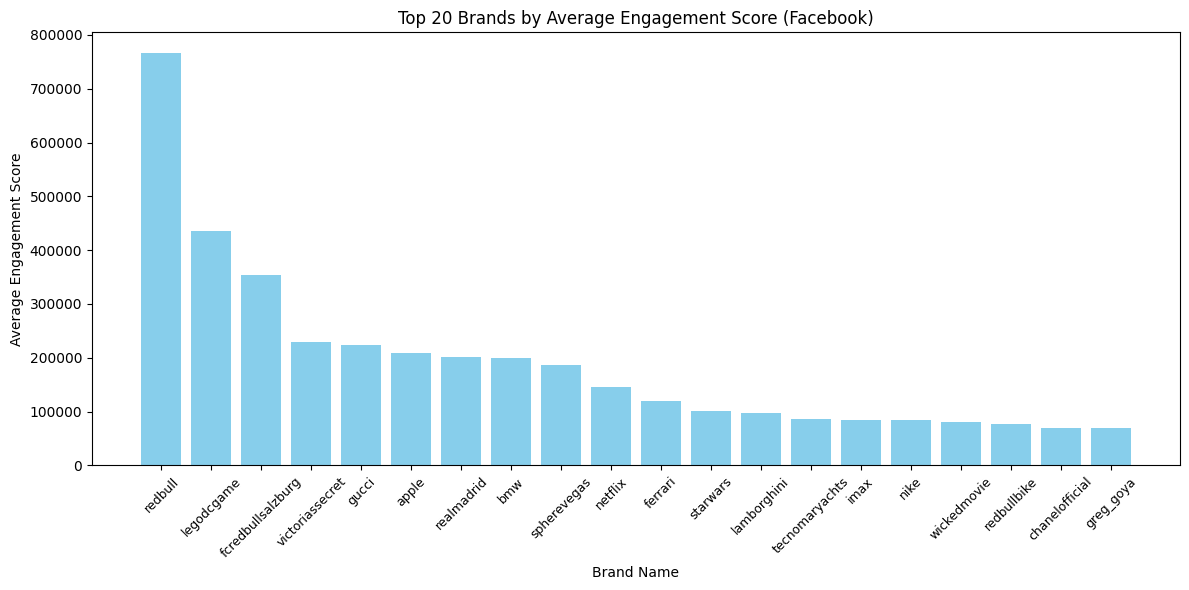

In [16]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# sort and select top 20
top20 = brand_engagement.sort_values(by='engagement_score', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top20['account_name'], top20['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Top 20 Brands by Average Engagement Score (Facebook)')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()


**we noticed that we have outlyers in columns.
now we will chk is iqr triming or iqr capping working good on outlyers**

In [17]:
lower_power=df['engagement_score'].quantile(0.25)
uper_power=df['engagement_score'].quantile(0.75)
iqr=uper_power-lower_power

In [18]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [19]:
#using iqr triming
df_trimmed = df[
    (df['engagement_score'] > lower_limit) &
    (df['engagement_score'] < upper_limit)
]

/tmp/ipython-input-2173630704.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-2173630704.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_trimmed['engagement_score'])


<Axes: ylabel='engagement_score'>

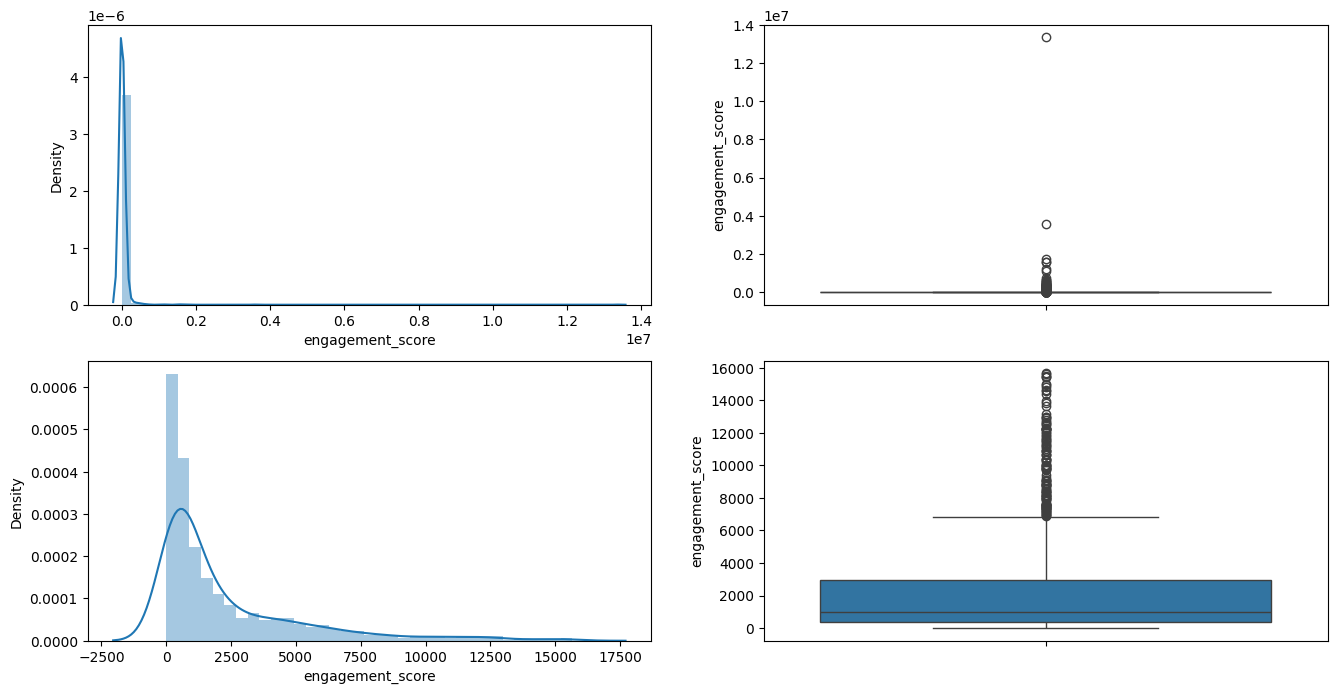

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])

plt.subplot(2,2,2)
sns.boxplot(df['engagement_score'])

plt.subplot(2,2,3)
sns.distplot(df_trimmed['engagement_score'])

plt.subplot(2,2,4)
sns.boxplot(df_trimmed['engagement_score'])

In [21]:
#using iqr capping method
new_df_cap=df.copy()
new_df_cap['engagement_score']=np.where(
    new_df_cap['engagement_score']>upper_limit,
    upper_limit,
    np.where(
        new_df_cap['engagement_score']<lower_limit,
        lower_limit,
        new_df_cap['engagement_score']
    )

)


/tmp/ipython-input-196828629.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-196828629.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['engagement_score'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7b1ee8434050>,
 'caps': [<matplotlib.lines.Line2D at 0x7b1ee8434650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b1ee8407d40>],
 'medians': [<matplotlib.lines.Line2D at 0x7b1ee8434cb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b1ee8434f80>],
 'means': []}

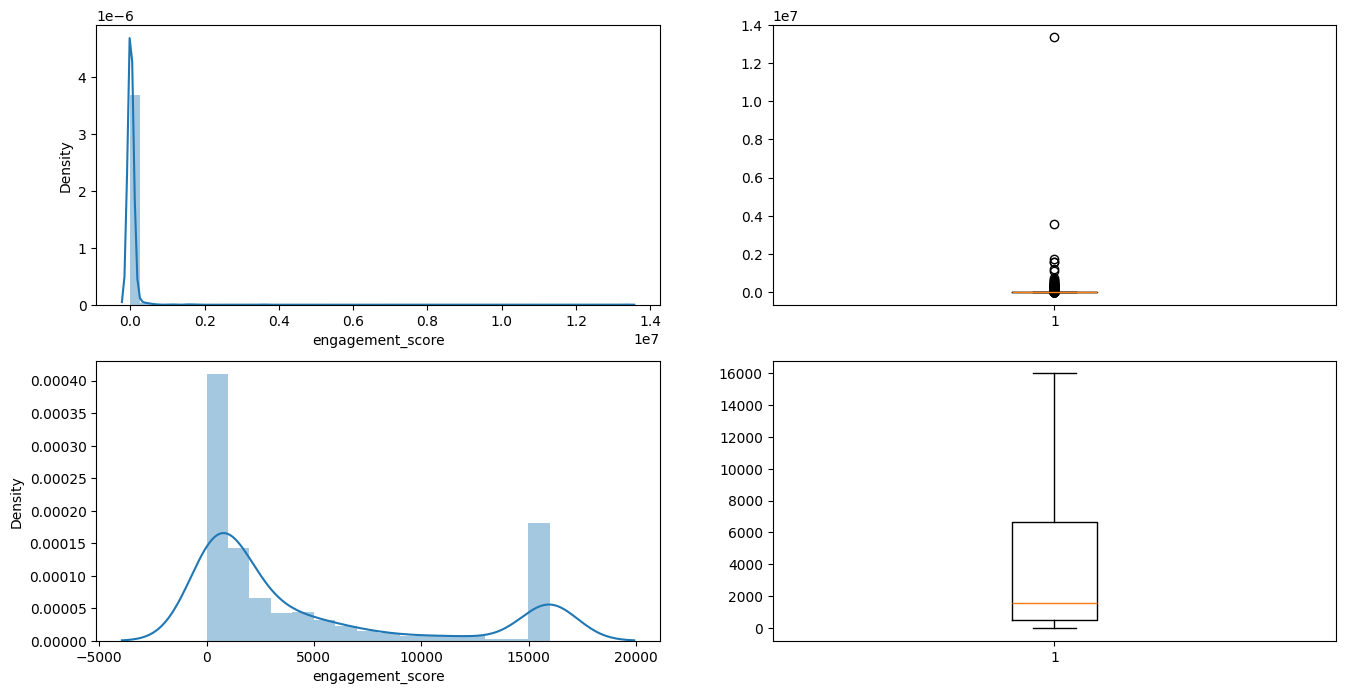

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])
plt.subplot(2,2,2)
plt.boxplot(df['engagement_score'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['engagement_score'])
plt.subplot(2,2,4)
plt.boxplot(new_df_cap['engagement_score'])

**now we will visualize Average Engagement Score per Brand after using iqr capping method**




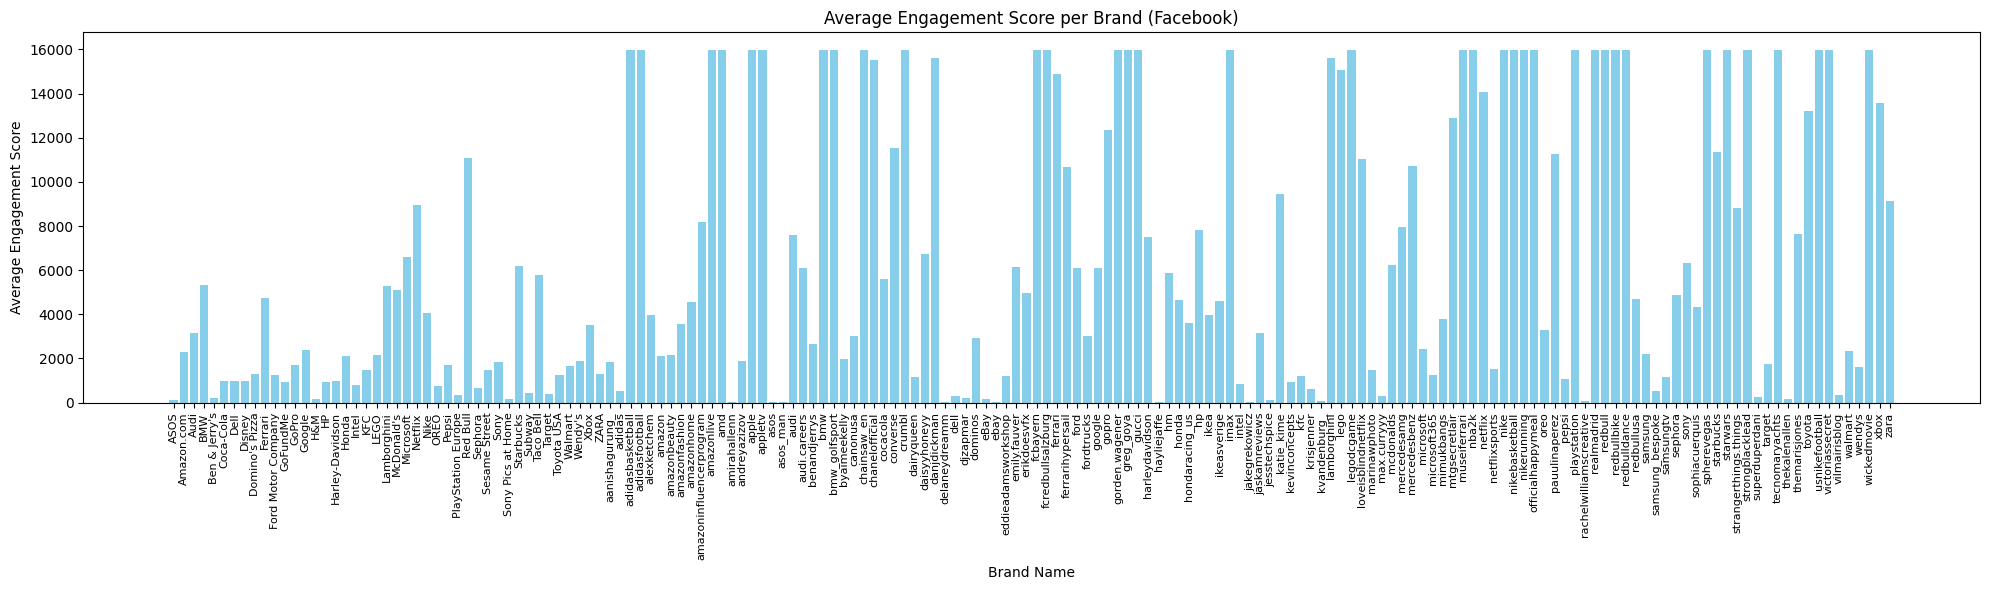

In [22]:
brand_engagement = new_df_cap.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

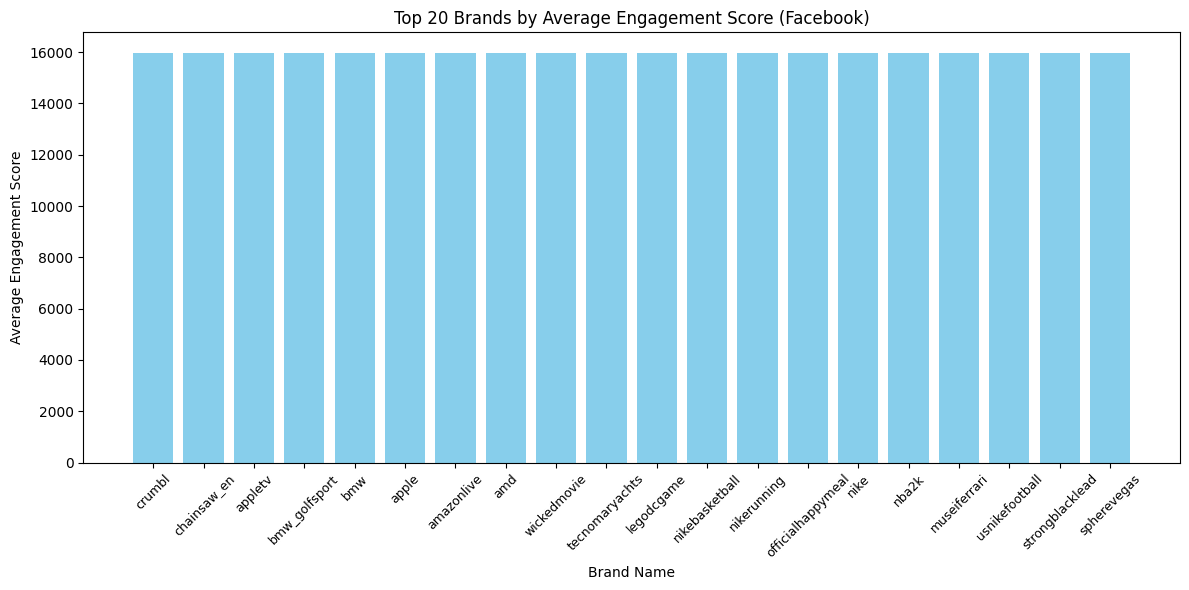

In [23]:
brand_engagement = new_df_cap.groupby('account_name')['engagement_score'].mean().reset_index()

# sort and select top 20
top20 = brand_engagement.sort_values(by='engagement_score', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top20['account_name'], top20['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Top 20 Brands by Average Engagement Score (Facebook)')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()


In [25]:
new_df_cap.describe()

,comment_count,like_count,caption_length,word_count,sentiment_score,engagement_score
count,1796.000000,1.796000e+03,1796.000000,1796.000000,1796.000000,1796.000000
mean,436.498330,3.005136e+04,190.222717,29.738307,0.158443,4702.605721
std,1716.816974,3.373496e+05,256.609823,41.033236,0.250448,5879.238862
min,0.000000,2.000000e+00,9.000000,1.000000,-1.000000,2.000000
25%,35.000000,3.927500e+02,69.000000,11.000000,0.000000,488.250000
50%,101.000000,1.312000e+03,128.000000,20.000000,0.100000,1558.500000
75%,307.000000,6.403250e+03,219.250000,34.000000,0.293797,6683.000000
max,46151.000000,1.329798e+07,4001.000000,658.000000,1.000000,15975.125000


 **we will use iqr capping method because it handling outlyers better then trimming.  now we will use it for like and comment also**


In [28]:
lower_power=new_df_cap['like_count'].quantile(0.25)
uper_power=new_df_cap['like_count'].quantile(0.75)
iqr=uper_power-lower_power


In [29]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [30]:
#using iqr capping method
newDf=new_df_cap.copy()
newDf['like_count']=np.where(
    newDf['like_count']>upper_limit,
    upper_limit,
    np.where(
        newDf['like_count']<lower_limit,
        lower_limit,
        newDf['like_count']
    )

)


{'whiskers': [<matplotlib.lines.Line2D at 0x7b1eea0b07a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b1eea0b2ae0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b1eea0b2a80>],
 'medians': [<matplotlib.lines.Line2D at 0x7b1eea0b37d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b1eea0b3e60>],
 'means': []}

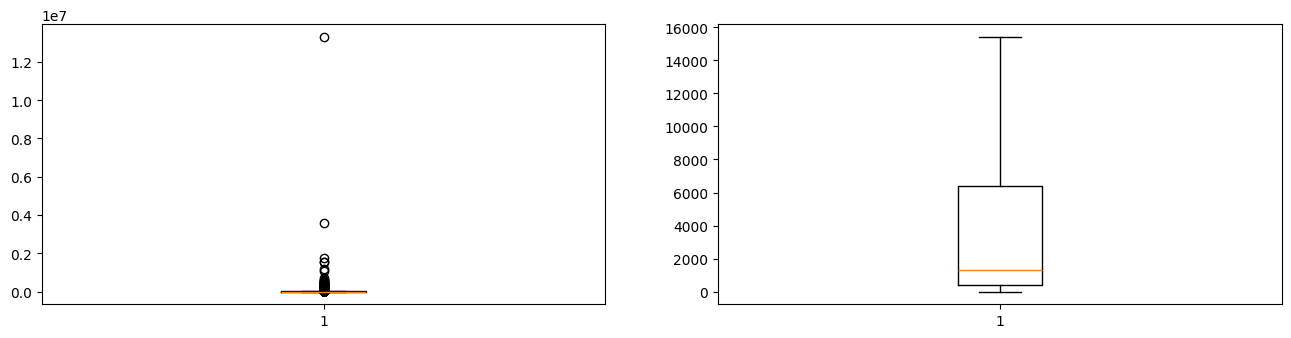

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['like_count'])
plt.subplot(2,2,2)
plt.boxplot(newDf['like_count'])

In [32]:
lower_power=newDf['comment_count'].quantile(0.25)
uper_power=newDf['comment_count'].quantile(0.75)
iqr=uper_power-lower_power

In [33]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [34]:
#using iqr capping method
Df=newDf.copy()
Df['comment_count']=np.where(
    Df['comment_count']>upper_limit,
    upper_limit,
    np.where(
     Df['comment_count']<lower_limit,
        lower_limit,
        Df['comment_count']
    )

)

{'whiskers': [<matplotlib.lines.Line2D at 0x7b1ee8509190>,
 'caps': [<matplotlib.lines.Line2D at 0x7b1ee8508440>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b1ee850a0c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b1ee8509850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b1ee85093d0>],
 'means': []}

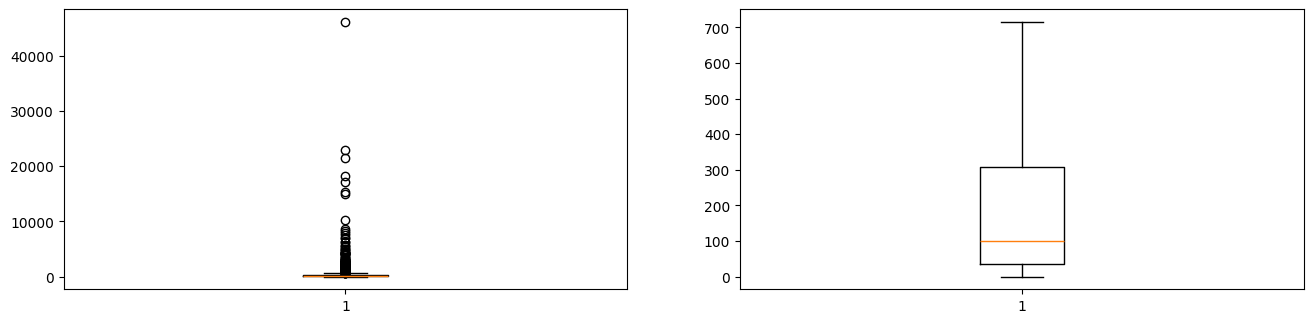

In [35]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['comment_count'])
plt.subplot(2,2,2)
plt.boxplot(Df['comment_count'])

In [26]:
new_df_cap.dtypes

,0
account_name,object
caption,object
comment_count,int64
like_count,int64
platform,object
caption_length,int64
word_count,int64
sentiment_score,float64
engagement_score,float64


**we are goin to plot again Correlation heatmap**

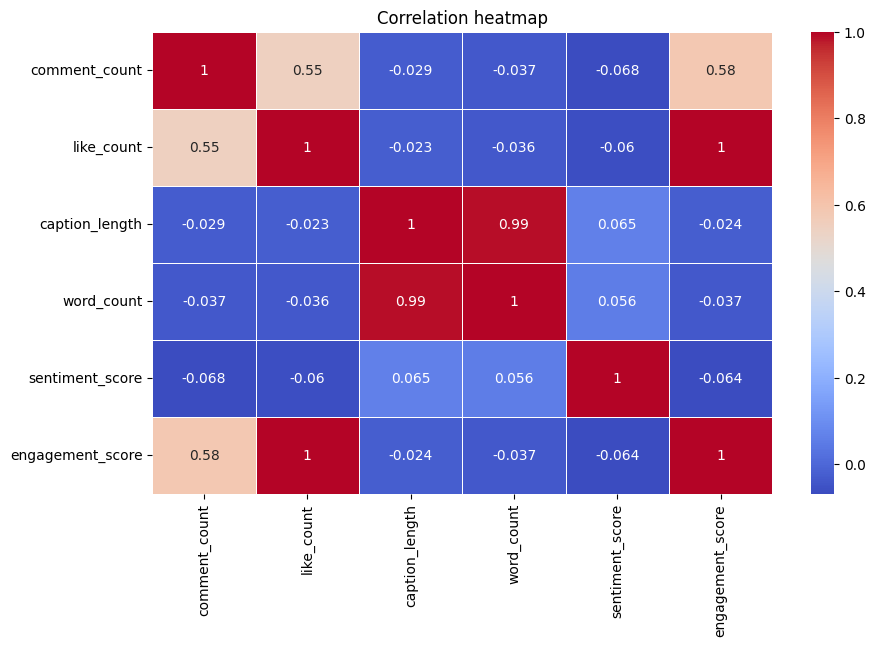

In [36]:
num_df = Df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

**now we are going to  initializes the data for training and testing**

In [ ]:
X=Df.drop(['engagement_score'],axis=1)
Y=Df['engagement_score']

In [38]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=42)
X_train

,account_name,caption,comment_count,like_count,platform,caption_length,word_count,sentiment_score
1733,honda,iconic honda prelude making return visit link ...,715.0,15419.0,Instagram,82,16,0.500000
1556,xbox,take favorite games wherever rog xbox ally rog...,715.0,15419.0,Instagram,111,21,0.500000
1641,gopro,rescuing baby shark goproawards recipient vinc...,112.0,15419.0,Instagram,315,49,0.250000
175,Wendy's,little allways went wendys school nd streeet s...,715.0,2521.0,Facebook,172,36,-0.138393
1102,target,laurenwolfe takes us behind scenes woolrich ta...,4.0,460.0,Instagram,189,29,-0.142857
...,...,...,...,...,...,...,...,...
1130,walmart,heard deals coming oct right hearing right,40.0,372.0,Instagram,74,13,0.285714
1294,starbucks,favorite drink add protein,238.0,4297.0,Instagram,37,6,0.500000
860,Amazon.com,eyes sameday delivery amazondelivery skeletons...,715.0,12985.0,Facebook,76,9,0.000000
1459,apple,lets dance commissioned apple new iphone pro b...,488.0,15419.0,Instagram,196,29,0.136364


In [39]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


**now we are going to use columntransformer to handle all columns. under the ColumnTransformer we will use vectorization and one hotencoder for our non numeric columns**

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        # 1️⃣ Apply TF-IDF on caption
        ('tfidf', TfidfVectorizer(stop_words='english'), 'caption'),

        # 2️⃣ One-Hot Encode account_name & platform
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'),
         ['account_name', 'platform']),

        # 3️⃣ Pass numeric columns as they are
        ('num', 'passthrough',
         ['comment_count', 'like_count', 'caption_length', 'word_count', 'sentiment_score'])
    ]
)

**making a pipeline for columntransformer and algorithm fiting**

In [41]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

In [42]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'caption'),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['account_name', 'platform']),
                                                 ('num', 'passthrough',
                                                  ['comment_count',
                                                   'like_count',
                                                   'caption_length',
                                                   'word_count',
                                                   'sentiment_score'])])),
                ('rf', RandomForestRegressor(random_state=42))])

**after training the model we are going to predict it using our testing  values**

In [43]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
y_pred

array([1.59751250e+04, 2.26350000e+02, 1.59751250e+04, 5.63800000e+02,
       6.19005000e+03, 1.35159000e+03, 5.22733000e+03, 2.83705000e+03,
       4.25330000e+02, 1.59713438e+04, 9.58400000e+01, 6.70763000e+03,
       5.22717000e+03, 1.59751250e+04, 3.29708000e+03, 9.56500000e+01,
       1.27800000e+02, 1.83756000e+03, 3.54100000e+01, 9.45950000e+02,
       6.26080000e+02, 1.59751250e+04, 8.81230000e+02, 1.85252000e+03,
       1.59551100e+04, 1.50653000e+03, 8.83160000e+02, 1.74330000e+02,
       5.08794000e+03, 2.44637000e+03, 1.59751250e+04, 2.80170000e+02,
       2.14688000e+03, 1.45287000e+03, 1.68532000e+03, 8.53510000e+02,
       5.82870000e+02, 1.59751250e+04, 2.36052000e+03, 6.86900000e+02,
       1.59751250e+04, 7.86510000e+02, 3.57455000e+03, 4.20716000e+03,
       6.44969000e+03, 5.72407000e+03, 4.45890000e+02, 8.59230000e+02,
       1.49960000e+02, 1.00065800e+04, 6.48450000e+02, 9.97427000e+03,
       4.82670000e+02, 3.86616000e+03, 4.66910000e+02, 1.39895000e+03,
      

**going to calculate the accuracy**

In [47]:
print("MSE:", mean_squared_error(Y_test, y_pred))
print("R2 Score:", r2_score(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))
print("MAE:", mean_absolute_error(Y_test, y_pred))



MSE: 42986.902523328994
R2 Score: 0.9985938005754236
RMSE: 207.3328303075251
MAE: 60.00702430555555
